In [1]:
import matplotlib.patches
import torch
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from osgeo import gdal
import geopandas as gpd
import rasterio as rio
import fiona
from rasterio import  plot
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from shapely.geometry.multipolygon import MultiPolygon
from rasterio import features

In [2]:
with open("apikey.txt", "r") as f:
    API_KEY = f.readlines()[0]

In [3]:
from torchgeo.datasets.spacenet import SpaceNet7 as sp7
from torchgeo.datasets.spacenet import SpaceNet6 as sp6
data = sp6(root='data', image='PS-RGB', transforms=None,download=False, api_key=API_KEY)
data2 = sp7(root='data', split="train", transforms=None, download=False, api_key=API_KEY, checksum=False)
data.collections

['sn6_AOI_11_Rotterdam']

In [4]:
# change to labels.geojson for spacenet7
data.label_glob = 'vector_labels.geojson'
data.label_glob

'vector_labels.geojson'

In [5]:
data.files = [  {'image_path': d['image_path'],
                'label_path': d['label_path'].replace("labels.geojson", "vector_labels.geojson")} for d in data.files]

In [6]:
def get_tiles(img_path, width=512, height=512):
    out = []
    ds = rio.open(img_path)
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = rio.windows.Window(col_off=128, row_off=128, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window = rio.windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = rio.windows.transform(window, ds.transform)
        out.append((window, transform))
    return out

In [7]:
# test random img
testimg = data.files[100]["image_path"]
testjson = data.files[100]["label_path"]
data.files[100]

{'image_path': 'data/spacenet6/sn6_AOI_11_Rotterdam/sn6_SN6_Train_AOI_11_Rotterdam_20190804120223_20190804120456_tile_64/PS-RGB.tif',
 'label_path': 'data/spacenet6/sn6_AOI_11_Rotterdam/sn6_SN6_Train_AOI_11_Rotterdam_20190804120223_20190804120456_tile_64-labels/vector_labels.geojson'}

In [8]:
tiles = get_tiles(testimg)
len(tiles)

4

In [9]:
testdf = gpd.read_file(testjson)
testdf

,roof_075mean,roof_075median,roof_075stdev,Building_ID,origarea,origlen,partialDec,truncated,geometry
0,3.330000,3.330000,0.000000,34132,22.934358,0,1.000000,0,"POLYGON Z ((594944.308 5751602.533 0.000, 5949..."
1,10.270000,10.270000,0.000000,35158,701.902548,0,0.016029,1,"POLYGON Z ((595135.591 5751607.422 0.000, 5951..."
2,33.205057,35.509998,15.294426,46092,22082.008630,0,0.062512,1,"POLYGON Z ((594995.859 5751614.173 0.000, 5950..."
3,11.350000,11.350000,0.000000,33814,3810.696464,0,0.455156,1,"POLYGON Z ((594717.024 5751529.736 0.000, 5947..."
4,14.000000,14.000000,0.000000,34663,6432.215410,0,1.000000,0,"POLYGON Z ((595006.110 5751387.070 0.000, 5950..."
5,12.370000,12.370000,0.000000,33347,6589.080368,0,0.936630,1,"POLYGON Z ((594693.153 5751383.493 0.000, 5946..."
6,23.410000,23.410000,0.000000,33684,18178.060645,0,0.724656,1,"POLYGON Z ((595097.733 5751395.894 0.000, 5950..."
7,14.420000,14.420000,0.000000,33861,750.198437,0,1.000000,0,"POLYGON Z ((594946.430 5751531.913 0.000, 5949..."
8,7.870000,7.870000,0.000000,34022,456.352566,0,1.000000,0,"POLYGON Z ((594934.397 5751563.997 0.000, 5949..."


In [10]:
def plot_gdf(gdf,ax=None,linewidth=0.5): # fill=False
    if ax is None:
        _,ax = plt.subplots(1,figsize=(10, 10))

    for geom in gdf['geometry']:
        # if fill:
        #     if isinstance(geom, MultiPolygon):
        #         geom = geom.geoms
        #         for g in geom:
        #             patch = PolygonPatch(g,linewidth=linewidth,color='fuchsia')
        #             ax.add_patch(patch)
        #     else:
        #         patch = PolygonPatch(geom,linewidth=linewidth,color='fuchsia')
        #         ax.add_patch(patch)
        # else:
        if isinstance(geom, MultiPolygon):
            geom = geom.geoms
            for g in geom:
                ax.plot(*g.exterior.xy,linewidth=linewidth)
        else:
            ax.plot(*geom.exterior.xy,linewidth=linewidth)
    return ax

<Axes: >

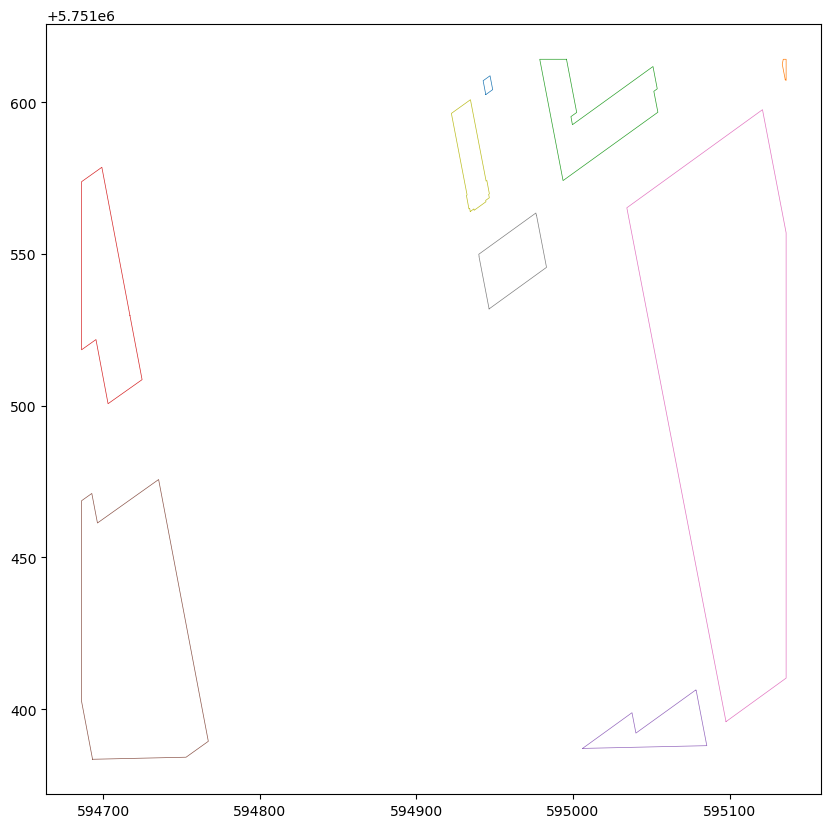

In [11]:
plot_gdf(testdf)

In [12]:
img = rio.open(testimg)

In [13]:
img.profile['crs']

CRS.from_epsg(32631)

In [14]:
img.bounds

BoundingBox(left=594686.1399464327, bottom=5751164.1761450535, right=595136.1367750834, top=5751614.1729737045)

In [15]:
img.transform

Affine(0.4999964762785847, 0.0, 594686.1399464327,
       0.0, -0.4999964762785847, 5751614.1729737045)

In [16]:
img.shape

(900, 900)

<Axes: >

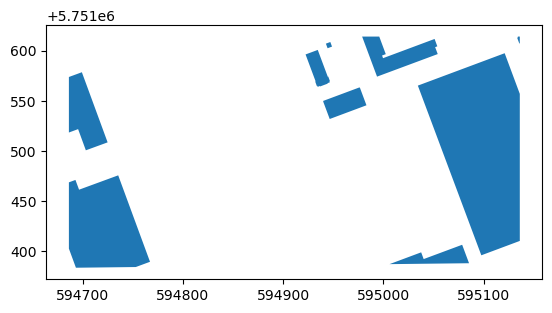

In [17]:
import matplotlib.pyplot as plt
p = gpd.GeoSeries(testdf['geometry'])
p.plot()

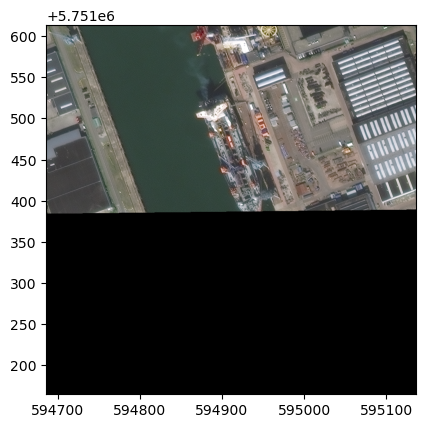

(900, 900)

In [18]:
plot.show(img)
img.shape

In [19]:
# test making mask
from geocube.api.core import make_geocube
import rioxarray

gpd1 = gpd.read_file(testjson)
gpd1["mask"] = 1

raster = rioxarray.open_rasterio(testimg, mask_and_scale=True)

mask = make_geocube(
    gpd1,
    measurements=["mask"],
    like=raster,
    fill=0,
)

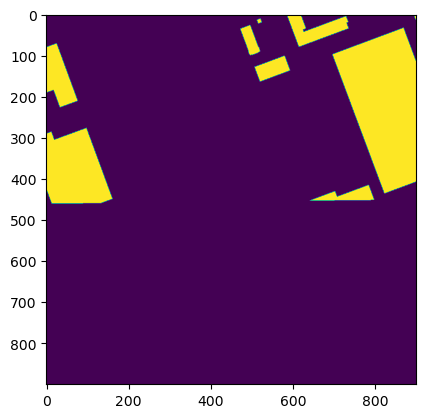

(900, 900)

In [20]:
plot.show(mask.to_array()[0,:,:].to_numpy())
mask.to_array()[0,:,:].to_numpy().shape

In [ ]:
import pathlib
from pathlib import PurePosixPath
from pathlib import Path
import os

import geocube
import skimage.io as io

# make masks
for idx in range(len(data.files)):
    try:
        gdf = gpd.read_file(data.files[idx]['label_path'])
        gdf["mask"] = 1

        raster = rioxarray.open_rasterio(data.files[idx]['image_path'], mask_and_scale=True)
        temp = make_geocube(gdf, measurements=["mask"], like=raster, fill=0)
        mask = temp.to_array()[0,:,:].to_numpy()

        savepath = "data/spacenet6_truncated"

        parts1 = PurePosixPath(data.files[idx]['image_path']).parts[-3:]
        img_path = os.path.join(savepath, PurePosixPath(*parts1))
        Path(img_path).parent.mkdir(parents=True, exist_ok=True)

        parts2 = PurePosixPath(data.files[idx]['label_path']).parts[-3:-1]
        label_path = os.path.join(savepath, PurePosixPath(*parts2), "mask.tif")
        Path(label_path).parent.mkdir(parents=True, exist_ok=True)

        # io.imsave(img_path, rio.open(data.files[idx]['image_path']).read(), plugin="tifffile", photometric="minisblack")
        # io.imsave(label_path, mask, plugin="tifffile", check_contrast=False)

    except geocube.exceptions.VectorDataError:
        pass

In [24]:
# check if masked saved correctly
testmasktif = "/Users/nish/PycharmProjects/SpaceNet7-Buildings-Detection/data/spacenet6_truncated/sn6_AOI_11_Rotterdam/sn6_SN6_Train_AOI_11_Rotterdam_20190804111224_20190804111453_tile_8679-labels/mask.tif"

In [25]:
test = io.imread(testmasktif)
type(test)

numpy.ndarray

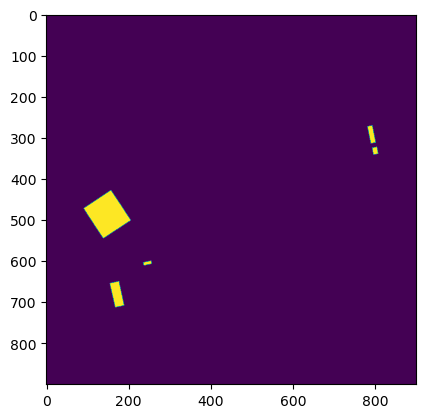

<Axes: >

In [26]:
plot.show(test)

In [ ]:
!python scripts/main.py --num_epochs 10 --exec_mode 'train'

In [8]:
import matplotlib.pyplot as plt

In [27]:
traininglog = open("/Users/nish/PycharmProjects/Satellite_Fusion/spacenet_detect/checkpoints/logs/base_dynunet_040923.out", "r").readlines()
trloss = [float(line.split("loss=")[1].split(",")[0]) for line in traininglog if "loss=" in line]

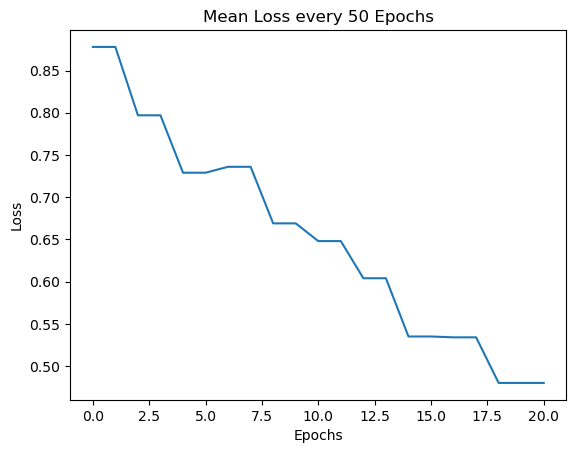

In [28]:
plt.plot(trloss)
plt.title("Mean Loss every 50 Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()